In [1]:
model_ckpt = "MCG-NJU/videomae-base" # pre-trained model from which to fine-tune
batch_size = 8 # batch size for training and evaluation

path to the MELD dataset videos which are reorganized in the following format
The names of the videos inside the folder can be anything. This is the standard way to organize datasets for classification.

MELD Dataset \
train \
----    Anger\
------     1.mp4\
------      2.mp4\
------     .\
------     .\
------     .\
----    Surprise\
------     1.mp4\
------     2.mp4\
------     .\
------     .\
------     .


test \
----    Anger\
------     1.mp4\
------      2.mp4\
------     .\
------     .\
------     .\
----    Surprise\
------     1.mp4\
------     2.mp4\
------     .\
------     .\
------     .


dev \
----    Anger\
------     1.mp4\
------      2.mp4\
------     .\
------     .\
------     .\
----    Surprise\
------     1.mp4\
------     2.mp4\
------     .\
------     .\
------     .


In [3]:
import pathlib
import os

dataset_root_path = "/media/cv/Extreme Pro1/MELD.Raw/reorganized_meld_data"
dataset_root_path = pathlib.Path(dataset_root_path)
assert os.path.exists(dataset_root_path) == True


find: ‘/media/cv/Extreme’: No such file or directory
find: ‘Pro1/MELD.Raw/reorganized_meld_data’: No such file or directory


In [6]:
# Read and check the count of all the videos available
video_count_train = len(list(dataset_root_path.glob("train/*/*.mp4")))
video_count_val = len(list(dataset_root_path.glob("dev/*/*.mp4")))
video_count_test = len(list(dataset_root_path.glob("test/*/*.mp4")))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 13707


In [7]:
# build a list of all the video files in the folders

all_video_file_paths = (
    list(dataset_root_path.glob("train/*/*.mp4"))
    + list(dataset_root_path.glob("dev/*/*.mp4"))
    + list(dataset_root_path.glob("test/*/*.mp4"))
)
all_video_file_paths[:5]

[PosixPath('/media/cv/Extreme Pro1/MELD.Raw/reorganized_meld_data/train/anger/dia39_utt16.mp4'),
 PosixPath('/media/cv/Extreme Pro1/MELD.Raw/reorganized_meld_data/train/anger/dia665_utt18.mp4'),
 PosixPath('/media/cv/Extreme Pro1/MELD.Raw/reorganized_meld_data/train/anger/dia1000_utt2.mp4'),
 PosixPath('/media/cv/Extreme Pro1/MELD.Raw/reorganized_meld_data/train/anger/dia1005_utt11.mp4'),
 PosixPath('/media/cv/Extreme Pro1/MELD.Raw/reorganized_meld_data/train/anger/dia1005_utt14.mp4')]

In [8]:
# infer class labels from the paths

class_labels = sorted({str(path).split("/")[-2] for path in all_video_file_paths})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

Unique classes: ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise'].


In [9]:
# Load the VideoMAE model and Image Processor for the model

from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification

image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# imports for processing videos from pytorch library
'''
The library has an import issue. It is broken and I think you need to fix the affine import in the library in one file.
If you get an error locate the file where error occurs and fix the affine import from functional library
'''
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

In [11]:
'''
Create Transforms that will be applied to the data and build datasets from using 
pytorch video library
'''
import os


mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps


# Training dataset transformations.
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop(resize_to),
                    RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)

# Training dataset.
train_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

# Validation and evaluation datasets' transformations.
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

# Validation and evaluation datasets.
val_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "dev"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

In [12]:
# We can access the `num_videos` argument to know the number of videos we have in the
# dataset.
train_dataset.num_videos, val_dataset.num_videos, test_dataset.num_videos

(9989, 1108, 2610)

In [14]:
sample_video = next(iter(train_dataset))
print("Sample Video Keys:",  sample_video.keys())

def investigate_video(sample_video):
    """Utility to investigate the keys present in a single video sample."""
    for k in sample_video:
        if k == "video":
            print(k, sample_video["video"].shape)
        else:
            print(k, sample_video[k])

    print(f"Video label: {id2label[sample_video[k]]}")


investigate_video(sample_video)

video torch.Size([3, 16, 224, 224])
video_name dia622_utt6.mp4
video_index 6178
clip_index 0
aug_index 0
label 4
Video label: neutral


In [15]:
"""
Utility functions to visualize the videos from the built dataset
"""

import imageio
import numpy as np
from IPython.display import Image


def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)


def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.
    
    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename


def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

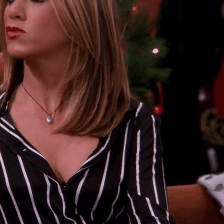

In [16]:
video_tensor = sample_video["video"]
display_gif(video_tensor)

In [17]:
# Defining hyperparameters for training

from transformers import TrainingArguments, Trainer

model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-meld"
num_epochs = 4

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1_score",
    max_steps= (train_dataset.num_videos // batch_size) * num_epochs,
    save_total_limit =3,
)

In [18]:
'''
Custom collator function that converts how data is fed from dataloader to the model
The modal takes pixel values as input for the whole video and labels if you want to compute a loss for the training.
'''
import torch

def collate_fn(examples):
    """The collation function to be used by `Trainer` to prepare data batches."""
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [19]:
'''
Hugging face trainer with custom metrics of f1_score and accuracy score
'''
from sklearn.metrics import accuracy_score, f1_score

trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics= lambda pred: {
        "accuracy": accuracy_score(pred.label_ids, pred.predictions.argmax(-1)),
        "f1_score": f1_score(pred.label_ids, pred.predictions.argmax(-1), average='weighted')
        },
    data_collator=collate_fn,
)

/home/cv/anaconda3/envs/tte/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [20]:
# training loop
trainer.train()

/home/cv/anaconda3/envs/tte/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
0,1.606100,1.641130,0.413245,0.241673
1,1.560200,1.647612,0.413245,0.241673
2,1.608300,1.679755,0.413245,0.241673
3,1.502400,1.669098,0.413245,0.241673
4,1.575800,1.647096,0.413245,0.241673
5,1.493200,1.648271,0.413245,0.241673
6,1.435200,1.632102,0.411921,0.241124
7,1.486700,1.640418,0.413907,0.243212
8,1.477100,1.645968,0.412583,0.243117
9,1.591900,1.684280,0.412583,0.250483


/home/cv/anaconda3/envs/tte/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/cv/anaconda3/envs/tte/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/cv/anaconda3/envs/tte/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/cv/anaconda3/envs/tte/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along

KeyboardInterrupt: 

In [ ]:
trainer.evaluate(test_dataset)

In [ ]:
'''
Saving the model

'''
trainer.save_model()
test_results = trainer.evaluate(test_dataset)
trainer.log_metrics("test", test_results)
trainer.save_metrics("test", test_results)
trainer.save_state()

## Inference

Using the model for inference

In [ ]:
trained_model = VideoMAEForVideoClassification.from_pretrained(new_model_name)

In [ ]:
sample_test_video = next(iter(test_dataset))
investigate_video(sample_test_video)

In [ ]:
def run_inference(model, video):
    """Utility to run inference given a model and test video.
    
    The video is assumed to be preprocessed already.
    """
    # (num_frames, num_channels, height, width)
    perumuted_sample_test_video = video.permute(1, 0, 2, 3)

    inputs = {
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),
        "labels": torch.tensor(
            [sample_test_video["label"]]
        ),  # this can be skipped if you don't have labels available.
    }
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    return logits

In [ ]:
logits = run_inference(trained_model, sample_test_video["video"])
display_gif(sample_test_video["video"])

In [ ]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])